# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [ ]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
m = Mystem()
from collections import Counter
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/data.csv')
data.info()
print(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB
   children  days_employed  dob_years education  education_id  \
0         1   -8437.673028         42    высшее             0   
1         1   -4024.803754         36   среднее             1   
2         0   -5623.422610         33   Среднее             1   
3         3   -4124.747207         32   среднее             1   
4  

**Вывод**

Довольно обширная таблица с одинаковым количеством пропусков в данных о стаже и доходе. Также бросается в глаза неверный вывод данных в столбце со стажем, нужно выяснить, из-за чего ошибка, и исправить.
Для начала изучим два столбца с пропусками и поймем их природу.

## Шаг 2. Предобработка данных

### Обработка пропусков

Проверим количество пропусков в столбцах и их характер.

In [ ]:
#print(data[data['total_income'].isna()].head())
print('Всего пропусков в столбце с доходом:', len(data[data['total_income'].isna()]))
#print(data[data['days_employed'].isna()].head())
print('Всего пропусков в столбце со стажем:', len(data[data['days_employed'].isna()]))
print('Пропуски составляют', len(data[data['days_employed'].isna()]) / len(data['days_employed']), 'данных.')
print(data.loc[ (data['days_employed'].isna()) & (data['total_income'].isna())].count())


Всего пропусков в столбце с доходом: 2174
Всего пропусков в столбце со стажем: 2174
Пропуски составляют 0.10099883855981417 данных.
children            2174
days_employed          0
dob_years           2174
education           2174
education_id        2174
family_status       2174
family_status_id    2174
gender              2174
income_type         2174
debt                2174
total_income           0
purpose             2174
dtype: int64


Пропуски в обеих столбцах совпадают, значит, скорее всего, это не случайность. Кроме того, они составляют 10% данных, избавляться от них нельзя. В задании категории стажа и дохода не упоминаются, но на всякий случай лучше привести эти данные в порядок. Начнем со столбца стажа. Его значения явно аномальные - встречаются и отрицательные, и слишком большие числа.

Количество отрицательных значений в стаже 15906
count     19351.000000
mean      63046.497661
std      140827.311974
min      -18388.949901
25%       -2747.423625
50%       -1203.369529
75%        -291.095954
max      401755.400475
Name: days_employed, dtype: float64


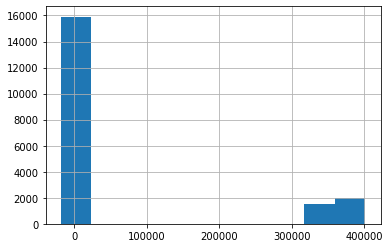

In [ ]:
print('Количество отрицательных значений в стаже', data[data['days_employed'] < 0].shape[0])
print(data['days_employed'].describe())
data['days_employed'].hist()
#Множество отрицательных значений может быть ошибкой ввода, а
#слишком большие числа, вероятно, обозначают не дни, а часы работы. 

In [ ]:
data['days_employed'] = data['days_employed'].apply(abs)
data['days_employed'] = data['days_employed'] / 365
data.rename(columns={'days_employed': 'years_employed'}, inplace=True)
print(data.head(10))
#Переведем отрицательный числа в модуль и для упрощения переведем стаж в годы.
#Аномальные числа сохраняются, они явно не обозначают годы работы.
#Поставим фильтр для правдоподобного стажа и приведем отличающиеся значения в норму.

   children  years_employed  dob_years education  education_id  \
0         1       23.116912         42    высшее             0   
1         1       11.026860         36   среднее             1   
2         0       15.406637         33   Среднее             1   
3         3       11.300677         32   среднее             1   
4         0      932.235814         53   среднее             1   
5         0        2.537495         27    высшее             0   
6         0        7.888225         43    высшее             0   
7         0        0.418574         50   СРЕДНЕЕ             1   
8         2       18.985932         35    ВЫСШЕЕ             0   
9         0        5.996593         41   среднее             1   

      family_status  family_status_id gender income_type  debt   total_income  \
0   женат / замужем                 0      F   сотрудник     0  253875.639453   
1   женат / замужем                 0      F   сотрудник     0  112080.014102   
2   женат / замужем           

In [ ]:
data['days_employed'].abs()

   children  years_employed  dob_years education  education_id  \
0         1       23.116912         42    высшее             0   
1         1       11.026860         36   среднее             1   
2         0        0.641943         33   Среднее             1   
3         3       11.300677         32   среднее             1   
4         0       38.843159         53   среднее             1   

      family_status  family_status_id gender income_type  debt   total_income  \
0   женат / замужем                 0      F   сотрудник     0  253875.639453   
1   женат / замужем                 0      F   сотрудник     0  112080.014102   
2   женат / замужем                 0      M   сотрудник     0  145885.952297   
3   женат / замужем                 0      M   сотрудник     0  267628.550329   
4  гражданский брак                 1      F   пенсионер     0  158616.077870   

                      purpose  
0               покупка жилья  
1     приобретение автомобиля  
2               поку

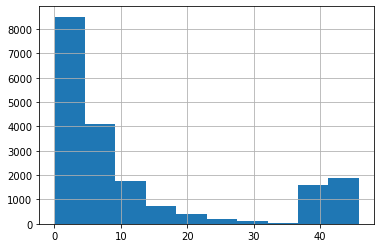

In [ ]:
data.loc[data['years_employed'] > (data['dob_years'] - 18), 'years_employed'] = data.loc[data['years_employed'] > (data['dob_years'] - 18), 'years_employed'] / 24
print(data.head(5))
data['years_employed'].hist()
print(data['years_employed'].describe())
#Данные выглядят реалистично, наконец можно перейти к замене пропусков.
#По статистике 0 значений в столбце нет, поэтому лучше заменим пропуски на медиану

In [ ]:
print('Средний стаж в целом:', data['years_employed'].median())
employee_years_median = data[data['income_type'] == 'сотрудник']['years_employed'].median()
print('Средний стаж сотрудника:', employee_years_median)
pensioner_years_median = data[data['income_type'] == 'пенсионер']['years_employed'].median()
print('Средний стаж пенсионера:', pensioner_years_median)
companion_years_median = data[data['income_type'] == 'компаньон']['years_employed'].median()
print('Средний стаж компаньона:', companion_years_median)
civil_years_median = data[data['income_type'] == 'госслужащий']['years_employed'].median()
print('Средний стаж госслужащего:', civil_years_median)

Средний стаж в целом: 5.6112191380189795
Средний стаж сотрудника: 4.040314675301438
Средний стаж пенсионера: 41.691016697001274
Средний стаж компаньона: 4.016660222461325
Средний стаж госслужащего: 6.701677937541498


Сравнили медианы стажа для каждой профессиональной категории заемщиков.
Стаж пенсионеров резко отличается, поэтому замена пропусков общим медианным значением может повлиять на статистику.
Лучше заменить пропуски у каждой категории именно их медианой.

   children  years_employed  dob_years education  education_id  \
0         1       23.116912         42    высшее             0   
1         1       11.026860         36   среднее             1   
2         0        0.641943         33   Среднее             1   
3         3       11.300677         32   среднее             1   
4         0       38.843159         53   среднее             1   

      family_status  family_status_id gender income_type  debt   total_income  \
0   женат / замужем                 0      F   сотрудник     0  253875.639453   
1   женат / замужем                 0      F   сотрудник     0  112080.014102   
2   женат / замужем                 0      M   сотрудник     0  145885.952297   
3   женат / замужем                 0      M   сотрудник     0  267628.550329   
4  гражданский брак                 1      F   пенсионер     0  158616.077870   

                      purpose  
0               покупка жилья  
1     приобретение автомобиля  
2               поку

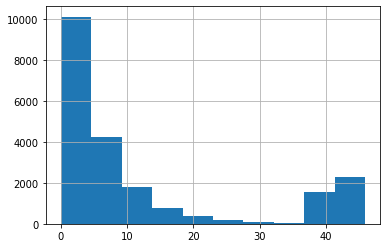

In [ ]:
data.loc[(data['years_employed'].isna()) & (data['income_type'] == 'сотрудник'), 'years_employed'] = employee_years_median
data.loc[(data['years_employed'].isna()) & (data['income_type'] == 'пенсионер'), 'years_employed'] = pensioner_years_median
data.loc[(data['years_employed'].isna()) & (data['income_type'] == 'компаньон'), 'years_employed'] = companion_years_median
data.loc[(data['years_employed'].isna()) & (data['income_type'] == 'госслужащий'), 'years_employed'] = civil_years_median
data.loc[data['years_employed'].isna(), 'years_employed'] = employee_years_median
print(data.head(5))
data['years_employed'].hist()
print(data['years_employed'].describe())
print('Пропусков осталось', data['years_employed'].isna().sum())

Теперь займемся пропусками во втором столбце. Рассмотрим его уникальные значения и средние показатели для каждой категории.
Распределение по категориям примерно одинаково как в таблице в целом, так и в строках с пропущенным значением.
Скорее всего, пропуски вызваны ошибками ввода или переноса данных.

count    1.935100e+04
mean     1.674223e+05
std      1.029716e+05
min      2.066726e+04
25%      1.030532e+05
50%      1.450179e+05
75%      2.034351e+05
max      2.265604e+06
Name: total_income, dtype: float64
Категории занятости заемщиков:
 сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64
Категории занятости заемщиков с пропущенным доходом:
 сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64


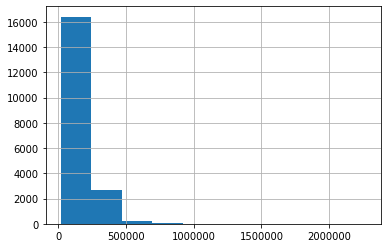

In [ ]:
print(data['total_income'].describe())
data['total_income'].hist()
print('Категории занятости заемщиков:\n', data['income_type'].value_counts())
print('Категории занятости заемщиков с пропущенным доходом:\n', data.loc[data['total_income'].isna()]['income_type'].value_counts())

In [ ]:
income_median = data['total_income'].median()
print('Общий медианный доход:', income_median)

employee_median = data[data['income_type'] == 'сотрудник']['total_income'].median()
print('Медианный доход сотрудника:', employee_median)

pensioner_median = data[data['income_type'] == 'пенсионер']['total_income'].median()
print('Медианный доход пенсионера:', pensioner_median)

companion_median = data[data['income_type'] == 'компаньон']['total_income'].median()
print('Медианный доход компаньона:', companion_median)
civil_median = data[data['income_type'] == 'госслужащий']['total_income'].median()
print('Медианный доход госслужащего:', civil_median)
#Размеры доходов отличны для каждой категории. Разумнее будет заменить пропуски медианами для каждой категории отдельно.

Общий медианный доход: 145017.93753253992
Медианный доход сотрудника: 142594.39684740017
Медианный доход пенсионера: 118514.48641164352
Медианный доход компаньона: 172357.95096577113
Медианный доход госслужащего: 150447.9352830068


In [ ]:
data.loc[(data['total_income'].isna()) & (data['income_type'] == 'сотрудник') , 'total_income'] = employee_median
data.loc[(data['total_income'].isna()) & (data['income_type'] == 'пенсионер') , 'total_income'] = pensioner_median
data.loc[(data['total_income'].isna()) & (data['income_type'] == 'компаньон') , 'total_income'] = companion_median
data.loc[(data['total_income'].isna()) & (data['income_type'] == 'госслужащий') , 'total_income'] = civil_median
data.loc[data['total_income'].isna(), 'total_income'] = income_median
print('Пропусков осталось\n', data.isna().sum())

Пропусков осталось
 children            0
years_employed      0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64


Явных пропущенных данных нет. Но нужно посмотреть данные и на неочевидные пропуски.
Займемся столбцом с возрастом заемщиков. Минимальное значение - 0, что противоречит правилам кредитования. Проверим, есть ли еще несовершеннолетние в таблице, и выясним, что аномальные значения столбца с возрастом - только нули. Скорее всего, ошибка вызвана человеческим фактором. 

In [ ]:
print(data['dob_years'].describe())
underage = data[data['dob_years'] == 0]['dob_years']
if underage.count() == data[data['dob_years'] < 18]['dob_years'].count():
    print('Все значения равны 0, других значений меньше 18 нет')
print('Значений, равных 0:', underage.count())

count    21525.000000
mean        43.293380
std         12.574584
min          0.000000
25%         33.000000
50%         42.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64
Все значения равны 0, других значений меньше 18 нет
Значений, равных 0: 101


Заменим нулевые значения медианным. Но для начала опять выделим пенсионеров в отдельную категорию, ведь их средний возраст будет отличаться от основной массы.

In [ ]:
pensioner_age_median = data.loc[(data['income_type'] == 'пенсионер') & (data['dob_years'] != 0)]['dob_years'].median()
data.loc[(data['income_type'] == 'пенсионер') & (data['dob_years'] == 0), 'dob_years'] = pensioner_age_median
age_median = data[data['dob_years'] != 0]['dob_years'].median()
data.loc[data['dob_years'] == 0, 'dob_years'] = age_median

Изучим все остальные столбцы с количественными значениями на предмет аномалий. 

In [ ]:
print(data['children'].describe())
print(data['education_id'].describe())
print(data['family_status_id'].describe())
print(data['debt'].describe())

count    21525.000000
mean         0.538908
std          1.381587
min         -1.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         20.000000
Name: children, dtype: float64
count    21525.000000
mean         0.817236
std          0.548138
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: education_id, dtype: float64
count    21525.000000
mean         0.972544
std          1.420324
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          4.000000
Name: family_status_id, dtype: float64
count    21525.000000
mean         0.080883
std          0.272661
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: debt, dtype: float64


В столбце с количеством детей явные ошибки - отрицательные дети, а также большое количество значений "20". Скорее всего, это либо опечатка, либо ошибка при переносе данных. Переведем "негативных" детей в "позитивные", а максимум детей к 0.

In [ ]:
print('Значения столбца с количеством детей:\n', data['children'].value_counts())
data.loc[data['children'] == 20, 'children'] = 0
data['children'] = data['children'].apply(abs)
print(data['children'].describe())

Значения столбца с количеством детей:
  0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64
count    21525.000000
mean         0.472660
std          0.750616
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: children, dtype: float64


**Вывод**

Явные пропуски в датафрейме обнаружены только в двух столбцах - с данными о стаже и доходе заемщиков. Причем, строки с отсутствующими данными в этих категориях совпадают. Можно предположить, что пропуски вызваны ошибками во вводе или переносе данных. Перед заполнением данные по стажу пришлось исправить, так как они были совсем неправдоподобными.
Чтобы заполнить пропуски, я вычислила медианные значения дохода и стажа по всей таблицы, а также для отдельных категорий, чтобы видеть, влияет ли категория занятости заемщика на эти показатели. Как оказалось, влияет, поэтому пропуски решено было заполнить медианами именно для нужной категории, а не для всего датафрейма.
Но помимо явных пропущенных значений в данных также обнаружились аномалии, требующие исправления. Они, скорее всего, были вызваны ошибками при заполнении или переносе данных, поэтому могли появлиять на результат исследования. Для заполнения также были использованы медианные или распространенные значения. 

Теперь пропуски заполнены, а таблица стала намного понятнее.


### Замена типа данных

Данные столбцов со стажем и доходом находятся в вещественном формате, что может помешать вычислениям. Для удобства переведем данные в целочисленный тип, используя метод astype.

In [ ]:
data = data.astype({'years_employed': int, 'total_income': int, 'dob_years': int})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
years_employed      21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


**Вывод**

Теперь данные либо целочисленные, либо строковые, что и понадобится нам для вычислений.

In [ ]:
columns = [col1, col2, col3]

for i in columns:
    df[i] = df[i].fillna(0)

### Обработка дубликатов

Теперь рассмотрим оставшиеся столбцы. Посчитаем явные дубликаты, а затем проверим уникальные значения на предмет неявных дубликатов.

In [ ]:
print('Дубликатов:', data.duplicated().sum())
print(data['family_status'].unique())
print(data['income_type'].unique())
print(data['education'].unique())
print(data['gender'].unique())
print('Неизвестных значений столбца с полом:', data[data['gender']=='XNA']['gender'].count())

Дубликатов: 54
['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']
['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']
['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']
['F' 'M' 'XNA']
Неизвестных значений столбца с полом: 1


Сразу бросаются в глаза разнообразные значения столбца с образованием. Приведем их к нижнему регистру для простоты восприятия. После форматирования число уникальных значений заметно сократилось.

In [ ]:
#print(data['education'].value_counts())
data['education'] = data['education'].str.lower()
print(data['education'].value_counts())

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64


In [ ]:
data = data.drop(np.where(data['gender'] == 'XNA')[0])

In [ ]:
data = data.drop_duplicates().reset_index(drop=True)
print('Дублирующихся значений', data.duplicated().sum())

Дублирующихся значений 0


Теперь удалим дубликаты и пропущенное значение столбца с полом, а затем посмотрим на результат.

In [ ]:
print(data.head(15))

    children  years_employed  dob_years            education  education_id  \
0          1              23         42               высшее             0   
1          1              11         36              среднее             1   
2          0               0         33              среднее             1   
3          3              11         32              среднее             1   
4          0              38         53              среднее             1   
5          0               2         27               высшее             0   
6          0               7         43               высшее             0   
7          0               0         50              среднее             1   
8          2               0         35               высшее             0   
9          0               5         41              среднее             1   
10         2              11         36               высшее             0   
11         0               2         40              среднее    

**Вывод**

Помимо очевидных дубликатов, одинаковые значения также были выявлены при изменении регистра. Таблица становится все понятнее.

### Лемматизация

In [ ]:
print(data['purpose'].value_counts())
purposes = data['purpose'].unique()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
жилье                                     646
покупка жилья                             646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка своего жилья                      620
покупка недвижимости                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

Заемщики указывают разные цели для кредита, но в конечном счете их можно объединить в несколько категорий. Чтобы их вычислить, лемматизируем слова из целей и посчитаем их количество. 

In [ ]:
purposes = str(data['purpose'].unique())
purpose_lemmas = m.lemmatize(purposes)
print(' '.join(purpose_lemmas))

[' покупка   жилье ' ' приобретение   автомобиль ' ' дополнительный   образование '
  ' сыграть   свадьба ' ' операция   с   жилье ' ' образование '
  ' на   проведение   свадьба ' ' покупка   жилье   для   семья ' ' покупка   недвижимость '
  ' покупка   коммерческий   недвижимость ' ' покупка   жилой   недвижимость '
  ' строительство   собственный   недвижимость ' ' недвижимость '
  ' строительство   недвижимость ' ' на   покупка   подержать   автомобиль '
  ' на   покупка   свой   автомобиль ' ' операция   с   коммерческий   недвижимость '
  ' строительство   жилой   недвижимость ' ' жилье '
  ' операция   со   свой   недвижимость ' ' автомобиль ' ' заниматься   образование '
  ' сделка   с   подержать   автомобиль ' ' получение   образование ' ' автомобиль '
  ' свадьба ' ' получение   дополнительный   образование ' ' покупка   свой   жилье '
  ' операция   с   недвижимость ' ' получение   высокий   образование '
  ' свой   автомобиль ' ' сделка   с   автомобиль ' ' профильный   о

In [ ]:
print(Counter(purpose_lemmas))

Counter({' ': 59, "' '": 23, "'\n": 14, " '": 14, 'покупка': 10, 'недвижимость': 10, 'автомобиль': 9, 'образование': 9, 'жилье': 7, 'с': 5, 'операция': 4, 'на': 4, 'свой': 4, 'свадьба': 3, 'строительство': 3, 'получение': 3, 'высокий': 3, 'дополнительный': 2, 'для': 2, 'коммерческий': 2, 'жилой': 2, 'подержать': 2, 'заниматься': 2, 'сделка': 2, "['": 1, 'приобретение': 1, 'сыграть': 1, 'проведение': 1, 'семья': 1, 'собственный': 1, 'со': 1, 'профильный': 1, 'сдача': 1, 'ремонт': 1, "']\n": 1})


Самыми популярными словами оказались "недвижимость", "автомобиль", "образование", "свадьба". Выделим цели в эти категории, для чего напишем функцию и применим ее для заполнения нового столбца.

In [ ]:
def categorize(purposes):
    purpose_lemmas = m.lemmatize(purposes)
    if 'недвижимость' in purpose_lemmas or 'жилье' in purpose_lemmas:
        return 'недвижимость'
    if 'автомобиль' in purpose_lemmas:
        return 'автомобиль'
    if 'образование' in purpose_lemmas:
        return 'образование'
    if 'свадьба' in purpose_lemmas:
        return 'свадьба'
    return 'прочее'

data['category'] = data['purpose'].apply(categorize)
print(data['category'])
print(data.head(15))

0        недвижимость
1          автомобиль
2        недвижимость
3         образование
4             свадьба
             ...     
21448    недвижимость
21449      автомобиль
21450    недвижимость
21451      автомобиль
21452      автомобиль
Name: category, Length: 21453, dtype: object
    children  years_employed  dob_years            education  education_id  \
0          1              23         42               высшее             0   
1          1              11         36              среднее             1   
2          0               0         33              среднее             1   
3          3              11         32              среднее             1   
4          0              38         53              среднее             1   
5          0               2         27               высшее             0   
6          0               7         43               высшее             0   
7          0               0         50              среднее             1   
8          

**Вывод**

Хотя в столбце и казалось много разных значений, благодаря лемматизации удалось вычислить их суть и выделить цели в несколько категорий, которыми удобно будет оперировать в исследовании.

### Категоризация данных

Еще немного "подчистим" данные. 

In [ ]:
print(data['family_status'].value_counts())

женат / замужем          12339
гражданский брак          4150
Не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64


In [ ]:
data['family_status'] = data['family_status'].str.lower()
print(data['family_status'].value_counts())

женат / замужем          12339
гражданский брак          4150
не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64


Также посмотрим на столбец с доходом. Пока эти цифры сложно использовать, лучше разбить их на категории, чтобы понять уровень дохода.

In [ ]:
print(data['total_income'].value_counts())

142594    1070
172357     502
118514     387
150447     145
150684       3
          ... 
101387       1
138249       1
280240       1
390148       1
264193       1
Name: total_income, Length: 18607, dtype: int64


Разбиваем весь массив данных на 4 подгруппы с названиями уровней дохода и распределяем по ним заемщиков.

In [ ]:
income_labels = ['низкий', 'средний', 'выше среднего', 'высокий']
data['income_level'] = pd.qcut(data['total_income'], q=4, labels=income_labels)
print(data.head(15))

    children  years_employed  dob_years            education  education_id  \
0          1              23         42               высшее             0   
1          1              11         36              среднее             1   
2          0               0         33              среднее             1   
3          3              11         32              среднее             1   
4          0              38         53              среднее             1   
5          0               2         27               высшее             0   
6          0               7         43               высшее             0   
7          0               0         50              среднее             1   
8          2               0         35               высшее             0   
9          0               5         41              среднее             1   
10         2              11         36               высшее             0   
11         0               2         40              среднее    

Выделим также категории возраста, их также можно использовать для расчетов.

In [ ]:
age_labels = ['молодые', 'средний возраст', 'пожилые']
data['age'] = pd.qcut(data['dob_years'], q=3, labels=age_labels)
print(data.head(15))

    children  years_employed  dob_years            education  education_id  \
0          1              23         42               высшее             0   
1          1              11         36              среднее             1   
2          0               0         33              среднее             1   
3          3              11         32              среднее             1   
4          0              38         53              среднее             1   
5          0               2         27               высшее             0   
6          0               7         43               высшее             0   
7          0               0         50              среднее             1   
8          2               0         35               высшее             0   
9          0               5         41              среднее             1   
10         2              11         36               высшее             0   
11         0               2         40              среднее    

**Вывод**

Таблица стала еще нагляднее, данные готовы для анализа.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [ ]:
report = data.groupby('children').agg({'debt': ['count', 'sum', 'mean']})
report.columns = ['всего', 'просрочки', '% просрочки']
print(report.sort_values(['% просрочки'], ascending=False).to_string(formatters={'% просрочки':'{:.2%}'.format}))

          всего  просрочки % просрочки
children                              
4            41          4       9.76%
2          2052        194       9.45%
1          4855        445       9.17%
3           330         27       8.18%
0         14166       1071       7.56%
5             9          0       0.00%


**Вывод**

Прямой зависимости нет, внизу списка и люди без детей, и многодетные семьи с 5 детьми. По семьям с 4 и 5 детьми выборка небольшая, поэтому категоричные выводы делать сложно. Но можно сказать, что у бездетных в целом процент оплаты кредита выше, чем у людей с детьми.

In [ ]:
data.groupby('children').agg({'debt': ['count', 'sum', 'mean']})

debt                
          count   sum      mean
children                       
0         14166  1071  0.075604
1          4855   445  0.091658
2          2052   194  0.094542
3           330    27  0.081818
4            41     4  0.097561
5             9     0  0.000000

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [ ]:
report = data.groupby('family_status').agg({'debt': ['count', 'sum', 'mean']})
report.columns = ['всего', 'просрочки', '% просрочки']
print(report.sort_values(['% просрочки'], ascending=False).to_string(formatters={'% просрочки':'{:.2%}'.format}))

                       всего  просрочки % просрочки
family_status                                      
не женат / не замужем   2810        274       9.75%
гражданский брак        4150        388       9.35%
женат / замужем        12339        931       7.55%
в разводе               1195         85       7.11%
вдовец / вдова           959         63       6.57%


**Вывод**

Одинокие люди чаще не возвращают кредиты, а побывавшие в браке чаще отдают кредиты вовремя. Самые надежные заемщики - овдовевшие люди.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [ ]:
report = data.groupby('income_level').agg({'debt': ['count', 'sum', 'mean']})
report.columns = ['всего', 'просрочки', '% просрочки']
print(report.sort_values(['% просрочки'], ascending=False).to_string(formatters={'% просрочки':'{:.2%}'.format}))

               всего  просрочки % просрочки
income_level                               
средний         5479        483       8.82%
выше среднего   5247        448       8.54%
низкий          5364        427       7.96%
высокий         5363        383       7.14%


**Вывод**

Ожидаемо, что люди с высоким доходом чаще возвращают кредиты вовремя. Но люди с низким доходом также довольно надежные заемщики.

- Как разные цели кредита влияют на его возврат в срок?

In [ ]:
report = data.groupby('category').agg({'debt': ['count', 'sum', 'mean']})
report.columns = ['total', 'debt', 'rate']
print(report.sort_values(['rate'], ascending=False))

              total  debt      rate
category                           
автомобиль     4306   403  0.093590
образование    4013   370  0.092200
свадьба        2324   186  0.080034
недвижимость  10810   782  0.072340


**Вывод**

Меньше всего просроченных платежей по кредитам за недвижимость, а кредиты на автомобили заметно чаще не выплачивают вовремя.

In [ ]:
report = data.groupby('education').agg({'debt': ['count', 'sum', 'mean']})
report.columns = ['всего', 'просрочки', '% просрочки']
report = report.sort_values(['% просрочки'], ascending=False)
print(report.to_string(formatters={'% просрочки':'{:.2%}'.format}))

                     всего  просрочки % просрочки
education                                        
начальное              282         31      10.99%
неоконченное высшее    743         68       9.15%
среднее              15172       1364       8.99%
высшее                5250        278       5.30%
ученая степень           6          0       0.00%


Маркер надежности заемщика - образование! Ни одного должника среди людей с ученой степенью, а люди только с начальным образованием чаще прочих не выплачивают кредит.

In [ ]:
report = data.groupby('age').agg({'debt': ['count', 'sum', 'mean']})
report.columns = ['всего', 'просрочки', '% просрочки']
report = report.sort_values(['% просрочки'], ascending=False)
print(report.to_string(formatters={'% просрочки':'{:.2%}'.format}))

                 всего  просрочки % просрочки
age                                          
молодые           7672        793      10.34%
средний возраст   7117        566       7.95%
пожилые           6664        382       5.73%


Еще один признак хорошего заемщика - возраст. Пожилые почти в два раза реже имеют проблемы с оплатой кредитов.

In [ ]:
report = data.groupby('income_type').agg({'debt': ['count', 'sum', 'mean']})
report.columns = ['всего', 'просрочки', '% просрочки']
report = report.sort_values(['% просрочки'], ascending=False)
print(report.to_string(formatters={'% просрочки':'{:.2%}'.format}))

                 всего  просрочки % просрочки
income_type                                  
в декрете            1          1     100.00%
безработный          2          1      50.00%
сотрудник        11084       1061       9.57%
компаньон         5077        376       7.41%
госслужащий       1457         86       5.90%
пенсионер         3829        216       5.64%
предприниматель      2          0       0.00%
студент              1          0       0.00%


In [ ]:
report = data.groupby('gender').agg({'debt': ['count', 'sum', 'mean']})
report.columns = ['всего', 'просрочки', '% просрочки']
report = report.sort_values(['% просрочки'], ascending=False)
print(report.to_string(formatters={'% просрочки':'{:.2%}'.format}))

        всего  просрочки % просрочки
gender                              
M        7279        747      10.26%
F       14174        994       7.01%


Судя по вычислениям, идеальный заемщик - пожилая женщина-студент с ученой степенью :))

## Шаг 4. Общий вывод

Изученные методы помогли в полной мере подготовить и изучить данные, чтобы определить зависимость между признаками заемщика и его надежностью. Первоначально в датафрейме были и пропуски, и дубликаты, как явные, так и нет. Скорее всего, они были вызваны ошибками при заполнении, а также различиями в методах заполнения (например, отрицательные данные и отличия величин в опыте работы). После исправления таблица стала более наглядной.

Прямой зависимости семейного положения и наличия детей на выплату кредита не отмечено, гораздо большее влияние имеют возраст, образование и пол. Но обнаруженные связи вполне могут помочь построить модель для оценки надежности заемщика.